# Tracking de experimentos com MLFlow

## 1 - Treinando e Trackeando o modelo - MLFlow

Etapa destinada ao treinamento e tracking de resultados de um modelo de classificação (SVC) de exemplo da biblioteca SKLearn, usando a funcionalidade de Pipeline e um dataset sintético criado aleatóriamente pela função make_classification. O Pipeline simula as etapas de pré-processamento e treinamento, aplicando a função StandardScaler() e o modelo SVC(), respectivamente.

No tracking dos experimentos, é usado o MLFlow. O MLflow é uma plataforma de código aberto para gerenciar o ciclo de vida de aprendizado de máquina de ponta a ponta. Ao realizar o tracking, o MLFlow registra parâmetros e resultados dos treinamentos, possibilitanto comparação visual posterior.


In [1]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

### 1.1 - Dividindo base em treino e teste

In [2]:
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

In [3]:
X_test[0:6]

array([[-0.16137354,  0.0275097 , -0.51104046,  0.8566997 ,  0.11403208,
         1.36741498, -0.1049797 ,  0.15364446, -1.61935998, -1.21286782,
         0.99428212,  0.28376955, -1.15820319,  2.23201639, -1.58447356,
         1.79444881,  0.84445431, -0.44358419, -0.28219588, -1.65534404],
       [ 0.08261103,  0.0189221 ,  0.53916127, -1.53716448,  0.07317121,
         1.01397215, -0.9571581 ,  0.58874241,  0.10058121, -1.00531187,
        -1.94989387,  0.10140715,  0.66207429, -0.08203415,  0.38432341,
        -0.82153452,  1.00971185,  1.10502647,  2.17116495, -1.73027606],
       [-0.0148577 ,  0.67057045, -0.21416666,  0.25020227,  0.05548937,
        -1.56699471,  0.03976673,  0.26568797,  1.84959125,  0.71998373,
         0.27713603, -1.10290621,  0.01927938, -0.7075057 ,  0.72310049,
         0.82140594,  0.02461213, -0.10486202, -0.10169727, -0.45130304],
       [-1.33425847,  0.69377315, -0.81299299, -1.41363563, -1.16940705,
         1.07774381, -0.13370156, -0.73067775, -

### 1.2 - Configurando o MLFlow

Para utilização do MLFLow, é necessário a instalação e inicialização prévia de um serviço do MLFlow. 

Para execução local: 
1. Instale o MLFlow: `pip install mlflow`
2. Inicie a UI: `mlflow ui`

Para começar a trackear os modelos, o serviço e o nome do experimento devem ser configurados como abaixo.


In [4]:
import mlflow

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('pipeline-example')

<Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='pipeline-example', tags={}>

### 1.3 - Treinando e armazenando artefatos do modelo

A realização do registro de métricas, parâmetros e modelos, pode ser realizada de duas formas:
1. Automatic Logging: Para bibliotecas compatíveis, loga automaticamente os artefatos do modelo.
2. Pode ser realizado o registro de forma personalizada, onde o cientista de dados inclui os artefatos que quiser.

#### 1.3.1 - Logando com autolog

O autolog permite registrar métricas, parâmetros e modelos sem a necessidade de instruções de registro explícitas. 

Existem duas formas de usar o autolog:

1. Chame `mlflow.autolog()` antes do código de treinamento. Isso habilitará o registro automático para qualquer biblioteca compatível que seja utilizada.
2. Execute autolog() especificando a biblioteca utilizada para treino. Exemplo: `mlflow.sklearn.autolog(disable=False)`. 

As seguintes bibliotecas são compatíveis: 
- Scikit-learn
- TensorFlow e Keras 
- Glúon
- XGBoost
- Name Light GBM
- Statsmodels 
- Spark
- Fastai
- Pytorch

Documentação: https://mlflow.org/docs/latest/tracking.html#automatic-logging

In [5]:
from sklearn import svm
from sklearn import datasets
from joblib import dump

mlflow.sklearn.autolog(disable=False)

with mlflow.start_run() as run:
    
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
    pipe.fit(X_train, y_train)
    print("Resultado do teste no modelo:", pipe.predict(X_test))
            
    score = pipe.score(X_test, y_test)
    
    print("Id da execução no MLFlow:", run.info.run_id)

2022/05/08 02:20:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/michel.arruda/.local/share/virtualenvs/bento-v1-XwOwfk9D/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/05/08 02:20:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/michel.arruda/.local/share/virtualenvs/bento-v1-XwOwfk9D/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`."
2022/05/

Resultado do teste no modelo: [1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0]
Id da execução no MLFlow: db1048fa4daf496e87c102d752afe5be


#### 1.3.2 - Logando de forma personalizada 

Para registro dos artefatos de forma personalizada podem ser utilizados diversos métodos. Abaixo alguns exemplos de uso:

- .log_model(model, 'remote_model_path') - Registra o modelo em um path, armazenando o .pickle e a lista de dependências
- .log_param("param_key", param_value) - Registra os parâmetros de entrada do modelo
- .log_metric("metric_key", metric_value) - Registra o valor de uma métrica aplicada a um modelo préviamente treinado.
- .log_artifact() registra um arquivo ou diretório local como um artefato, opcionalmente pegando um attribute_path para colocá-lo no URI do artefato da execução. Os artefatos de execução podem ser organizados em diretórios, para que você possa colocar o artefato em um diretório dessa maneira.
- .set_tag("key", "value") - Define uma tag na execução atual.


Exemplos de uso:
- mlflow.sklearn.log_model(model, 'arquivos_modelo')
- mlflow.log_param('svc__degree', 3)
- mlflow.log_metric('Score', 0.88)
- mlflow.log_artifact("results/matriz_confusao.png")
- mlflow.set_tag("release.version", "2.2.0")


Resultado do teste no modelo: [1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0]


/Users/michel.arruda/.local/share/virtualenvs/bento-v1-XwOwfk9D/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Id da execução no MLFlow: 04592031c85849f0bb8eb3b9bab5189a


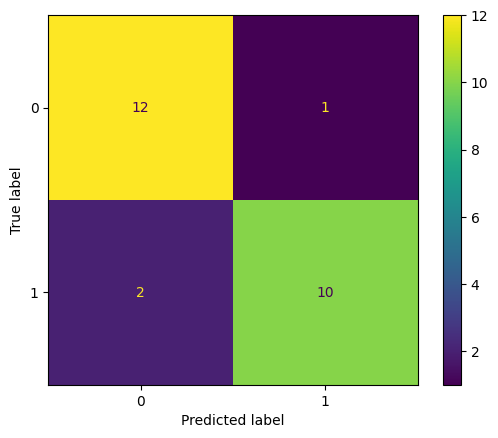

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

mlflow.sklearn.autolog(disable=True)

with mlflow.start_run() as run:

    # Treinando modelo
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
    pipe.fit(X_train, y_train)
    print("Resultado do teste no modelo:", pipe.predict(X_test))
    
    # Tracking - Modelo
    mlflow.sklearn.log_model(pipe, 'model')
    
    # Tracking - Score
    score = pipe.score(X_test, y_test)
    mlflow.log_metric('score', score)
    
    # Tracking - Matrix de Confusao
    plot_confusion_matrix(pipe, X_test, y_test)  
    plt.savefig("results/matriz_confusao.png")
    mlflow.log_artifact("results/matriz_confusao.png")
    
    # Execucao do MLFlow
    print("Id da execução no MLFlow:", run.info.run_id)

### 1.4 - Informações da execução no MLFlow

In [7]:
run_info = mlflow.get_run(run.info.run_id)
run_info

<Run: data=<RunData: metrics={'score': 0.88}, params={}, tags={'mlflow.log-model.history': '[{"run_id": "04592031c85849f0bb8eb3b9bab5189a", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-05-08 05:20:53.681325", "flavors": '
                             '{"python_function": {"model_path": "model.pkl", '
                             '"loader_module": "mlflow.sklearn", '
                             '"python_version": "3.8.12", "env": '
                             '"conda.yaml"}, "sklearn": {"pickled_model": '
                             '"model.pkl", "sklearn_version": "1.0.2", '
                             '"serialization_format": "cloudpickle"}}, '
                             '"model_uuid": '
                             '"6fd14ac922fc41e4baedd2e5e858cb77"}]',
 'mlflow.source.name': '/Users/michel.arruda/.local/share/virtualenvs/bento-v1-XwOwfk9D/lib/python3.8/site-packages/ipykernel_launcher.py',
 'mlflow.source.

In [8]:
import ast
history = ast.literal_eval(run_info.data.tags["mlflow.log-model.history"])
artifact_path = history[0]["artifact_path"]
model_path = history[0]["flavors"]["python_function"]["model_path"]
pkl_path = run_info.info.artifact_uri + "/"+ artifact_path + "/" + model_path

print("URL dos atefatos: ", run_info.info.artifact_uri)
print("Caminho dos artefatos: ", artifact_path)
print("Caminho do model: ", model_path)
print("Identificador da execução: ", run_info.info.run_id)
print("Caminho para o .pkl: ", pkl_path)

URL dos atefatos:  ./mlruns/2/04592031c85849f0bb8eb3b9bab5189a/artifacts
Caminho dos artefatos:  model
Caminho do model:  model.pkl
Identificador da execução:  04592031c85849f0bb8eb3b9bab5189a
Caminho para o .pkl:  ./mlruns/2/04592031c85849f0bb8eb3b9bab5189a/artifacts/model/model.pkl
